## This Notebook is for determining wave pdfs for alongshore transport, to ensure that the AST module matches the master

In [1]:
import os
import numpy as np
import sys
import scipy 
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pytest
sys.path.append("..")

In [2]:
os.getcwd()

'C:\\Users\\Lexi\\PycharmProjects\\brie\\notebooks'

In [3]:
# os.chdir("..\\brie")
# path=os.getcwd()
# os.listdir(path)

In [4]:
from brie.brie import Brie
from brie.lexi_brie import Lexi_Brie
from brie.alongshore_transporter import AlongshoreTransporter

We are going to initialize the classes with shoreline positions and wave angles ("seeding"). There are 2 brie classes, the original Master Brie (brie) and the modified Brie (lexi_brie). There is currently only one alongshore transporter class

In [5]:
# initializing the brie and ast classes with shorelines and wave angles
xs=np.asarray([0, 0, 0, 100, 100, 100, 200, 200, 200, 300, 300, 300, 200, 200, 200, 100, 100, 100, 0, 0, 0])
wave_angle=np.asarray([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45])
brie = Brie(inlet_model=False, bseed=True, alongshore_section_count=21, xs=xs, wave_angle=wave_angle)
lexi_brie = Lexi_Brie(inlet_model=False, bseed=True, alongshore_section_count=21, xs=xs, wave_angle=wave_angle)
transporter = AlongshoreTransporter(shoreline_x=xs,  wave_distribution=lexi_brie._wave_dist)

Once the classes have been initialized, we are going to compare sections of their current code for ast. There are discrepancies between the wave pdfs that we will explore here, starting with the wave angles and steps. 

<div class="alert alert-block alert-info"><b>NOTE:</b> master brie is in degrees, whereas AST is in radians.</div>

In [6]:
# master code
master_angle_array, m_step = np.linspace(-90.0, 90.0, brie._wave_climl, retstep=True)
print("shape of master angles:", np.shape(master_angle_array))

# alongshore transporter code
n_bins = 181
all_angles, step = np.linspace(-np.pi / 2.0, np.pi / 2.0, n_bins, retstep=True)
print("shape of ast angles:", np.shape(all_angles))
print("master step:", m_step, " degrees")
print("ast step:", np.rad2deg(step), " degrees")

shape of master angles: (180,)
shape of ast angles: (181,)
master step: 1.005586592178771  degrees
ast step: 1.0  degrees


Immediately, we see that there are differences in the wave angles and steps. The master brie file does not use 1 degree angle steps, whereas the ast model does. This is determined by the bin size, which is 180 in the master and 181 in AST. If we change the ast model to reflect the master, we get:

In [7]:
# using 180 bins instead for ast 
# alongshore transporter code
n_bins = 180
all_angles_180, step_180 = np.linspace(-np.pi / 2.0, np.pi / 2.0, n_bins, retstep=True) # radians 
print("shape of ast angles:", np.shape(all_angles_180))
print("master step:", m_step, " degrees")
print("ast step:", np.rad2deg(step_180), " degrees")
if master_angle_array == pytest.approx(np.rad2deg(all_angles_180)) and m_step == pytest.approx(np.rad2deg(step_180)):
    print("True")
else:
    print("False")

shape of ast angles: (180,)
master step: 1.005586592178771  degrees
ast step: 1.0055865921787708  degrees
True


Now the angle arrays and steps are approximately equal. Moving forward through the code, we are looking for wave pdfs. In the master code, this comes from Wave Angle Generator, but both the master code and ast model use the same .pdf function. The pdf function requires an input of wave angle or angles. It then returns the value for `self._wave_pdf()` at that angle. `self._wave_pdf` is defined using the SciPy interpolate 1D function (interp1d). It takes an x and y, which in this case, `x = np.deg2rad(np.array([-90.0, -45.0, 0.0, 45.0, 90]))` and f is defined (kind of) from eqn 25 in Nienhuis and Lorenzo-Trueba 2019. Interp1d also takes the kind of interpolation, which is specified as "next" in this case. So basically, it returns a coninuous line/function based on the points given. Therefore, when we call `.pdf(angle)` we are really calling `self._wave_pdf(angle)`

In [8]:
from brie.waves import WaveAngleGenerator

In [9]:
asymmetry=brie._wave_asym
high_fraction=brie._wave_high
print("asymmetry is:", brie._wave_asym)
print("fraction of high waves is:", brie._wave_high)
x = np.deg2rad(np.array([-90.0, -45.0, 0.0, 45.0, 90]))
f = (
    np.array(
        [
            0.0,
            asymmetry * high_fraction,
            asymmetry * (1.0 - high_fraction),
            (1.0 - asymmetry) * (1.0 - high_fraction),
            (1.0 - asymmetry) * high_fraction,
        ]
    )
    * 4.0
    / np.pi
)
print("x array:", x)
print("f array:", f)
full_wave_pdf = interp1d(x, f, kind="next", bounds_error=False, fill_value=0.0)
type(full_wave_pdf)
# plt.plot(full_wave_pdf)

asymmetry is: 0.8
fraction of high waves is: 0.2
x array: [-1.57079633 -0.78539816  0.          0.78539816  1.57079633]
f array: [0.         0.20371833 0.81487331 0.20371833 0.05092958]


scipy.interpolate.interpolate.interp1d

That was essentially all the behind the scenes setup of what is occuring when we perform the next calcs. In the Master Brie file, our angles of interest come from WaveAngleGenerator. In order to access the angles, you must use angles.next() which I think is why "next" is the type of interpolation performed. Again, we take the `master_angle_array`, and put it into the pdf function. This means we are just getting the value from the interpolated full wave pdf (above) at each of the angles form master_angle_array. I think when we call angles.pdf, this is allowing us to access the angles generated. (what do they actually correlate to?)

<div class="alert alert-block alert-danger"><b>WARNING:</b> Re-running the following code will update/change the variables (master_wave_pdf specifically).</div>

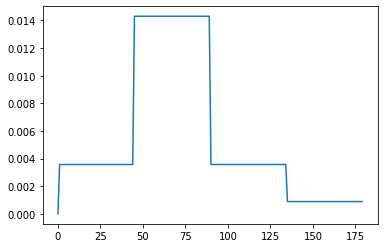

In [10]:
angles = WaveAngleGenerator(asymmetry=brie._wave_asym, high_fraction=brie._wave_high)
master_angle_array = np.deg2rad(master_angle_array)
m_step = np.deg2rad(m_step)
master_wave_pdf = angles.pdf(master_angle_array) * m_step  # wave climate pdf, needs input in radians
plt.plot(master_wave_pdf)

Now lets take a look at lexi_brie/AST module. We start by setting teh wave distribution, which is based on the ashton function from WaveAngleGenerator. The distribution coming from the ashton function should be the same as the `angles` variable from the WaveAngleGenerator (?)

In [11]:
from brie.waves import ashton

In [12]:
asymmetry=lexi_brie._wave_asym
high_fraction=lexi_brie._wave_high
print("asymmetry is:", brie._wave_asym)
print("fraction of high waves is:", brie._wave_high)
wave_dist = ashton(a=asymmetry, h=high_fraction, loc=-np.pi / 2, scale=np.pi)
type(wave_dist)

asymmetry is: 0.8
fraction of high waves is: 0.2


scipy.stats._distn_infrastructure.rv_frozen

Is there a way to test the comparison of wave_dist and angles??

This `wave_dist` variable then gets initialized into alongshore transporter as the `wave_distribution` variable and ultimately to `self._wave_distribution`. Nothing else happens until we call `lexi_brie.update()`. When we do that, and the ast_model_on is True, we update the ast module by one time step. This starts with calling the `build_matrix()` function, inputting the `self._wave_distribution` as wave_distribution (back to that variable name) along with other variables. From the build matrix function, the `calc_coast_diffusivity()` function is called which takes the PDF wave distribution and shoreline angles (wave_distribution.pdf). 

Long story short: we use wave_dist.pdf (should be the same as angles.pdf from Master (?)
(not exactly sure why we do this first instead of combining with wave_dist.pdf(all_angles) * step

In [13]:
ast_wave_pdf = wave_dist.pdf

Then, we perform similar calcs to the master brie. we already know from cell 7 that to get the same angles used in master_angle_array, that we need 180 bins instead of 181. 

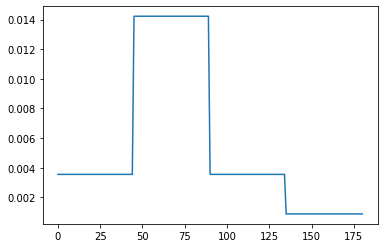

In [14]:
# same code from cell 7 above
n_bins = 180
all_angles_180, step_180 = np.linspace(-np.pi / 2.0, np.pi / 2.0, n_bins, retstep=True) # radians 
# same as master_wave_pdf:
e_phi_0 = ast_wave_pdf(all_angles) * step  
plt.plot(e_phi_0)

We can immediately see that there is a slight difference in this wave pdf (it does not start at 0), although the actual function should be the same (?). We know that the angles match based on the first analysis done in cell 7. So this means that wave_dist.pdf does not equal angle.pdf.

<!-- The shoreline angles come from the `calc_shoreline_angles()` function, which takes inputs shoreline position and dy spacing. In our given shoreline positions, they steadily increase then decrease. Whenever there is a change in position (e.g. from 0 to 100), there is a non-zero angle.  -->

In [15]:
# note to self: think I accidentally deleted the cell above this one

# from brie.alongshore_transporter import calc_shoreline_angles
# shoreline_angles = calc_shoreline_angles(xs, spacing=lexi_brie._dy)

# fig, ax1 = plt.subplots() 
# ax1.set_xlabel('X-axis') 
# ax1.set_ylabel('shoreline position', color = 'red') 
# ax1.plot(xs, color = 'red') 
# ax1.tick_params(axis ='y', labelcolor = 'red') 
# # Adding Twin Axes
# ax2 = ax1.twinx() 
# ax2.set_ylabel('shoreline angles (radians)', color = 'blue') 
# ax2.plot(shoreline_angles, color = 'blue') 
# ax2.tick_params(axis ='y', labelcolor = 'blue') 
# # Show plot
# plt.show()

# tests for waves (from katherine)

At the end of `test_wave_generator.py` there is a function for testing ashton to WaveAngleGenerator. 

True


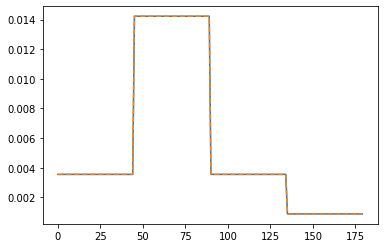

In [16]:
test_angle_array, test_step = np.linspace(-89.5, 89.5, 180, retstep=True)
dist = ashton(a=0.8, h=0.2, loc=-90, scale=180)
ashton_pdf = dist.pdf(test_angle_array) * test_step
waves = WaveAngleGenerator(asymmetry=0.8, high_fraction=0.2)
waves_pdf = waves.pdf(np.deg2rad(test_angle_array)) * np.deg2rad(test_step)
if waves_pdf == pytest.approx(ashton_pdf):
    print("True")
else:
    print("False")

plt.plot(ashton_pdf)
plt.plot(waves_pdf, linestyle='dashed')

When we used that specific angle array, the pdfs match, but based on the original code, we need to wave angles to be between -90 and 90, so the next cell shows that when we use that range of angles, they no longer match

False


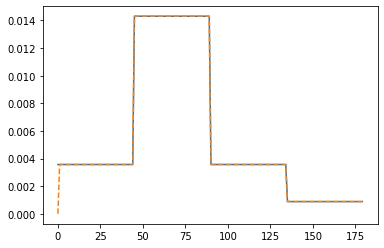

In [17]:
test_angle_array, test_step = np.linspace(-90, 90, 180, retstep=True)
dist = ashton(a=0.8, h=0.2, loc=-90, scale=180)  # do we need to change this scale??
ashton_pdf = dist.pdf(test_angle_array) * test_step
waves = WaveAngleGenerator(asymmetry=0.8, high_fraction=0.2)
waves_pdf = waves.pdf(np.deg2rad(test_angle_array)) * np.deg2rad(test_step)
if waves_pdf == pytest.approx(ashton_pdf):
    print("True")
else:
    print("False")

plt.plot(ashton_pdf)
plt.plot(waves_pdf, linestyle='dashed')

Do we want to just force the first value in the ashton_pdf to be 0?

True


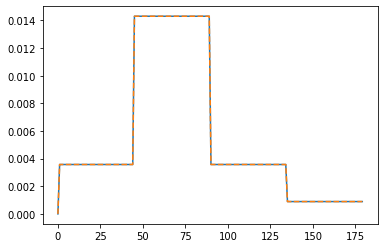

In [18]:
test_angle_array, test_step = np.linspace(-90, 90, 180, retstep=True)
dist = ashton(a=0.8, h=0.2, loc=-90, scale=180)  # do we need to change this scale??
ashton_pdf = dist.pdf(test_angle_array) * test_step
waves = WaveAngleGenerator(asymmetry=0.8, high_fraction=0.2)
waves_pdf = waves.pdf(np.deg2rad(test_angle_array)) * np.deg2rad(test_step)
ashton_pdf[0] = 0
if waves_pdf == pytest.approx(ashton_pdf):
    print("True")
else:
    print("False")
    
plt.plot(ashton_pdf)
plt.plot(waves_pdf, linestyle='dashed')

Need to lookk into what is happening behind the scenes of WaveAngleGenerator and Ashton